In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matplotlib.colors import LogNorm

from scipy.signal import savgol_filter


import os, re

import seaborn as sns
sns.set_theme(font_scale=1.5)

# Read in ELFIN data

In [2]:
path = 'data/ELFIN/'
names = ['event1.txt', 'event2.txt',
         'event3.txt', 'event4.txt',
         'event5.txt', 'event6.txt',
         'event7.txt']

# Energy bins in keV
e_bins = np.array([63.245541,   97.979584,       
                   138.56409,   183.30309,
                   238.11758,       305.20490,
                   385.16229,       520.48047,
                   752.99396,       1081.6653,
                   1529.7061,       2121.3203,
                   2893.9602,       3728.6064,
                   4906.1206,       6500.0000])

def get_ELFIN_data(eventNumber):
    
    with open(path + names[eventNumber-1], "r") as f:
        hemi = f.readline()
        f.readline() 
        R = f.readline()
        R += f.readline()
        R += f.readline()        
                
    pa_bins = np.array([float(x) for x in R.split()][1:-1])
        
    data = pd.read_csv(path + names[eventNumber-1], names=pa_bins, skiprows=7, sep='\s+')
        
    data.fillna(0, inplace=True)   
    
    if eventNumber == 4 or eventNumber == 5:
        data.drop(len(data)-1, inplace=True)
        
    # Flip data so now field-aligned down is always 0 degrees
    if hemi.split()[0] == "SOUTH":
        data = data.iloc[:, ::-1]
    elif hemi.split()[0] == "NORTH":
        pass
    else:
        raise ValueError("Unclassified hemisphere!")
        
    return pa_bins, data
    

def plot2D_data(e_bins, pa_bins, counts):
    
    X, Y = np.meshgrid(e_bins, pa_bins)

    plt.figure(figsize=(16,5)); plt.subplot(1,3,1)
    #plt.figure(figsize=(5,5))
    plt.pcolormesh(X, Y, counts.T, norm=LogNorm());
    
    if ~( (counts == 0).all() ):
        plt.colorbar(label='Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ MeV$^{-1}$]')
    #label='Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ MeV$^{-1}]$'
    plt.xscale('log')
    plt.xlabel('Energy [keV]')
    plt.ylabel('Pitch Angle [deg]');
    plt.ylim(0, 180)
    
    plt.yticks([0, 30, 60, 90, 120, 150, 180])
    plt.hlines(90, 0.5e2, 0.5e4, 'k', linestyle='-')
    plt.hlines(67.76, 0.5e2, 0.5e4, 'k', linestyle='--')
    plt.hlines(112.24, 0.5e2, 0.5e4, 'k', linestyle='--')
    
    EbinCentersMeV  = 1e-3 * np.hstack([e_bins[:-1] + np.diff(e_bins), e_bins[-1]])
    PAbinCentersRad = np.deg2rad( np.hstack([pa_bins[:-1] + np.diff(pa_bins), pa_bins[-1]]) )
    
    plt.subplot(1,3,2); 
    #plt.figure(figsize=(5,5)); 
    plt.grid(True, which='both')
    for i in range(0, len(pa_bins)):
        
        plt.loglog(e_bins, 2 * np.pi * counts[:, i] * np.sin(PAbinCentersRad[i]), 
                   c=[0, 1-i/len(pa_bins), i/len(pa_bins)]);
    
    plt.xlabel('Energy [keV]')
    plt.ylabel('Flux [cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]')

    
    #fitSomething(e_bins, pa_bins, counts)
    
    plt.subplot(1,3,3); 
    #plt.figure(figsize=(5,5)); 
    plt.grid(True, which='both')
    for i in range(0, len(e_bins)):
        
        plt.semilogy(pa_bins, counts[i, :] * EbinCentersMeV[i], c=[1-i/len(e_bins), 0, i/len(e_bins)])
        

    plt.xlabel('Pitch Angle [deg]')
    plt.xlim(0, 180)
    plt.ylabel('Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
        
    M = np.nanmax(2*np.pi*counts)
    if(np.isinf(M)):
        M = 1e5
    N = np.nanmin(2*np.pi*counts)
    if N<0:
        N = 1e-5
    
    M /= 0.5e2
        
    plt.vlines(90,     N, M*1.5, 'k', linestyle='-')
    plt.vlines(67.76,  N, M*1.5, 'k', linestyle='--')
    plt.vlines(112.24, N, M*1.5, 'k', linestyle='--')
    
    plt.ylim(N, M*1.5)
    plt.xticks([0, 30, 60, 90, 120, 150, 180])
    
    plt.tight_layout()
    
def getTotalFlux(e_bins, pa_bins, counts, alpha1, alpha2):

    try:
        counts = counts.values
    except:
        counts = counts
    
    # Restrict pitch angle bins to those of interest
    r_pa_bins = pa_bins[(pa_bins > alpha1) & (pa_bins < alpha2)]
    
    MeV_to_eV = 1e-6
    
    intFlux = 2 * np.pi * np.trapz( 
        np.trapz(MeV_to_eV * counts[:, ((pa_bins > alpha1) & (pa_bins < alpha2))] * 
                 e_bins[:,np.newaxis]  * 1e3 , 
                 x=e_bins*1e3, axis=0) * np.sin(np.deg2rad(r_pa_bins)), 
                 x=np.deg2rad(r_pa_bins))
    
    return intFlux

From 
$$f(E,\alpha) ~~~[cm^{-2} ~s^{-1} ~sr^{-1} ~MeV^{-1}]$$

$$\int_\Omega \int_E f(E,\alpha) ~E~ dE~ d\Omega$$

$$\int_\theta \int_\alpha \int_E f(E,\alpha) ~E~ dE~ \sin(\alpha) ~d\alpha~d\theta$$

Assumption: 

$$\Delta \Omega \approx \int \int \sin(\alpha) ~d\alpha ~d\theta = -2\pi~ cos(\alpha)|_{\alpha_l}^{\alpha_u}$$

$$= 2\pi \left(\cos(\alpha_l) - \cos(\alpha_u)\right)$$

Therefore, we get energy flux
$$-->2\pi \sum_E \sum_\alpha f(E, \alpha) E \Delta E \left(\cos(\alpha_l) - \cos(\alpha_u)\right) ~~~[eV/cm^2/s]$$

$$f(\alpha) = \int_E f(E,\alpha) ~dE = \sum_i f(E_i, \alpha) ~\Delta E_i$$

$$f(E) = \int_\Omega f(E,\alpha) ~d\Omega = 2\pi \int_\alpha f(E,\alpha) ~sin(\alpha)~d\alpha$$


In [3]:
from scipy.optimize import curve_fit

def fitSomething(e_bins, pa_bins, counts):
    
    def powerLaw(x, alpha, f0):
        emin = e_bins[0]-10
        return f0 * (alpha - 1)/emin * (x/emin)**(-alpha)
    
    def exponential(x, E0, f0):
        return f0 * 1 / E0 * np.exp(-x / E0)
    
    def doubleExponential(x, E01, E02, f01, f02):
        return f01 / E01 * np.exp(-x / E01) + f02 / E02 * np.exp(-x / E02)
        
    ebinLimit = -5    
    for i in range(0, len(pa_bins)):
        
        if np.any(np.isnan(counts[:ebinLimit, i])) or np.any(counts[:ebinLimit, i] == 0):
            continue
                            
        try:
            popt1, _ = curve_fit(powerLaw, e_bins[:ebinLimit], counts[:ebinLimit, i],
                                p0=[ 2, counts[:ebinLimit, i][0] ], maxfev=3000)

            '''
            popt2, _ = curve_fit(exponential, e_bins[:ebinLimit], counts[:ebinLimit, i])
            popt3, _ = curve_fit(doubleExponential, e_bins[:ebinLimit], counts[:ebinLimit, i])
            ''';

            plt.loglog(e_bins[:ebinLimit], powerLaw(e_bins[:ebinLimit], *popt1), '--', 
                       c=[0, 1-i/len(pa_bins), i/len(pa_bins)]);
        except(RuntimeError, ValueError):
            pass

        '''
        plt.loglog(e_bins[:ebinLimit], exponential(e_bins[:ebinLimit], *popt2), '.-', 
                   c=[0, 1-i/len(pa_bins), i/len(pa_bins)]);
            
        plt.loglog(e_bins[:ebinLimit], doubleExponential(e_bins[:ebinLimit], *popt3), '.', 
                   c=[0, 1-i/len(pa_bins), i/len(pa_bins)]);
        '''

In [4]:
#ALCANGLE = 114
ALCANGLE = 100
LCANGLE  = 60

RUNLISTLIMIT = 15

# Plots of EMIC precipitation events from L.C.

Event 1, energy flux = 4.254e+09 eV cm^-2 s^-1, total ionization: 1.2e+08 cm^-2 s^-1


/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


Event 2, energy flux = 2.778e+10 eV cm^-2 s^-1, total ionization: 7.9e+08 cm^-2 s^-1
Event 3, energy flux = 2.411e+10 eV cm^-2 s^-1, total ionization: 6.9e+08 cm^-2 s^-1
Event 4, energy flux = 6.415e+09 eV cm^-2 s^-1, total ionization: 1.8e+08 cm^-2 s^-1
Event 5, energy flux = 1.307e+10 eV cm^-2 s^-1, total ionization: 3.7e+08 cm^-2 s^-1
Event 6, energy flux = 7.385e+09 eV cm^-2 s^-1, total ionization: 2.1e+08 cm^-2 s^-1
Event 7, energy flux = 7.684e+09 eV cm^-2 s^-1, total ionization: 2.2e+08 cm^-2 s^-1
Event 8, energy flux = 4.254e+09 eV cm^-2 s^-1, total ionization: 1.2e+08 cm^-2 s^-1


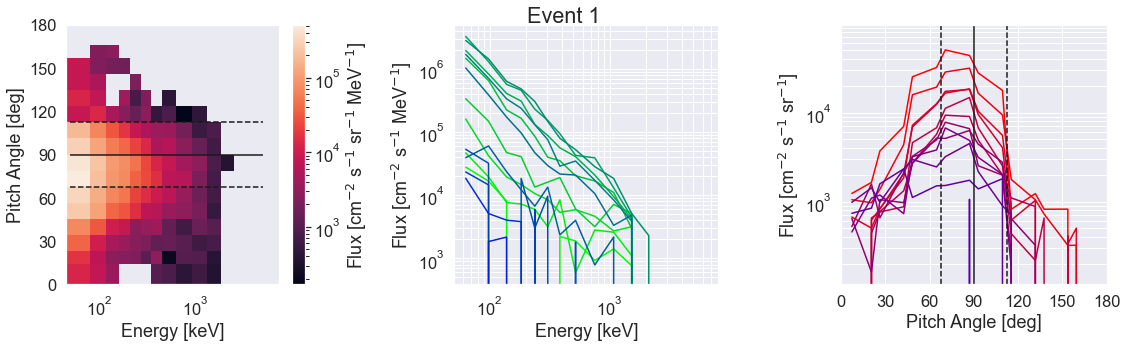

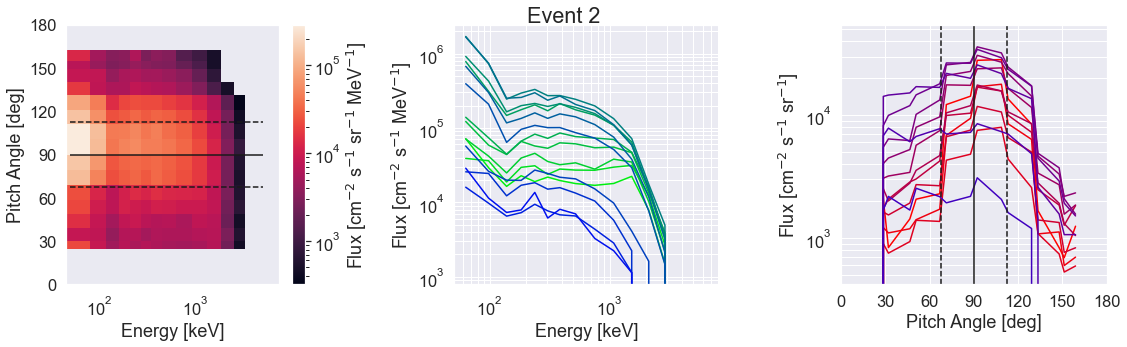

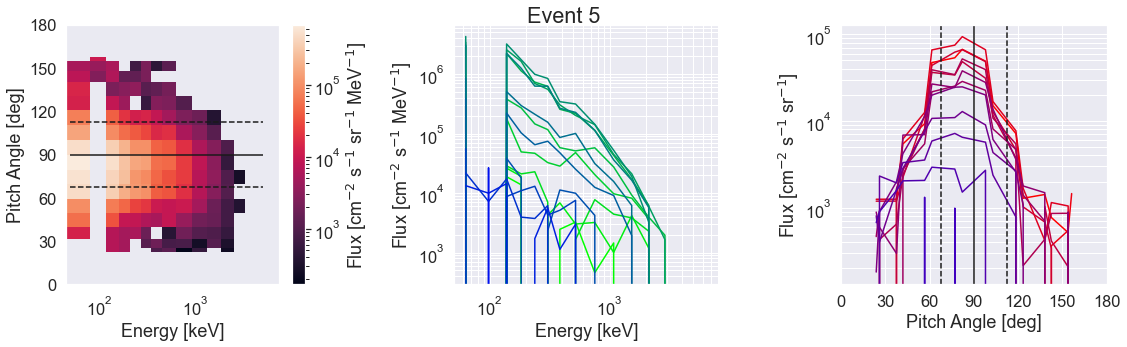

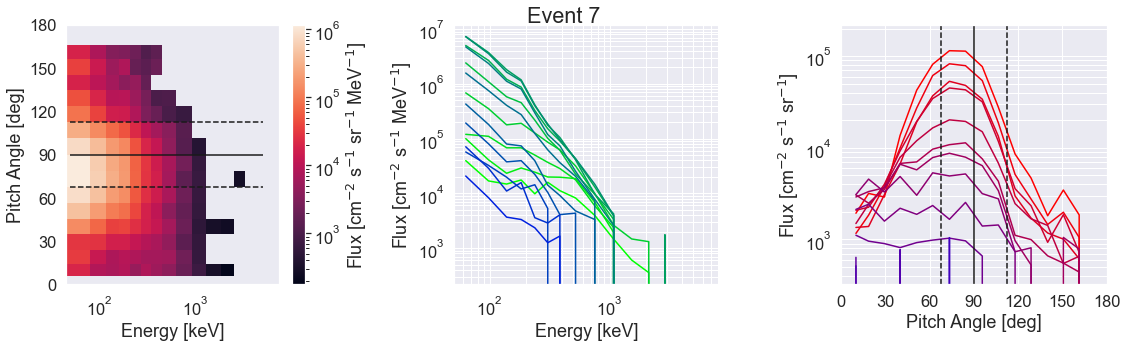

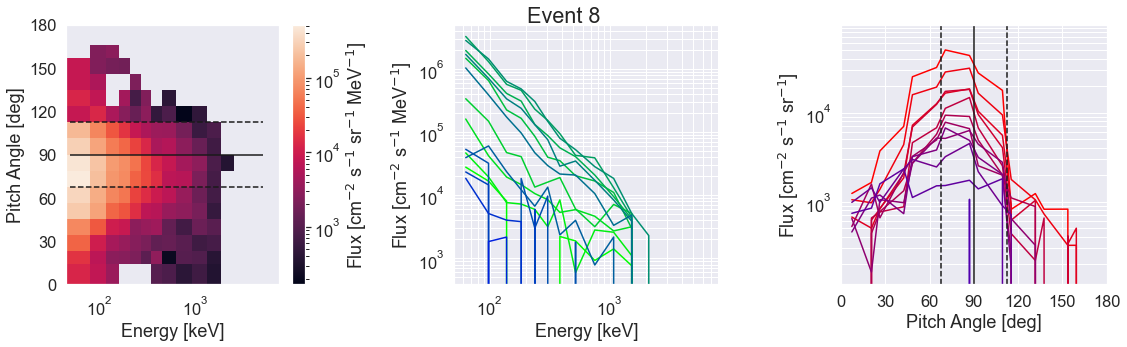

In [5]:
for i in range(0, 8):
    
    pa_bins, counts = get_ELFIN_data(i)
    
    f_energy = getTotalFlux(e_bins, pa_bins, counts, 0, LCANGLE)
    
    print("Event %.0f, energy flux = %.3e eV cm^-2 s^-1, total ionization: %.1e cm^-2 s^-1" % 
          (i+1, f_energy, f_energy / 35))
    plot2D_data(e_bins, pa_bins, counts.values)
    
    plt.suptitle('Event %.0f' % (i+1))
    
    #plt.savefig('./figures/Event_%0.f_fullData.pdf' % (i+1), bbox_inches='tight')

In [7]:
avg_pa_bins = np.array([5.0000000,       15.000000,
                        25.000000,       35.000000,
                        45.000000,       55.000000,
                        65.000000,       75.000000,
                        85.000000,       95.000000,
                        105.00000,       115.00000,
                        125.00000,       135.00000,
                        145.00000,       155.00000,
                        165.00000,       175.00000])

avg_data = pd.read_csv(path + 'event_average.txt', names=avg_pa_bins, skiprows=33, sep='\s+')
        
avg_data.fillna(0, inplace=True)   

f_energy = getTotalFlux(e_bins, pa_bins, counts, 0, LCANGLE)

plot2D_data(e_bins, avg_pa_bins, avg_data.values);
#plt.suptitle('ELFIN Data Averaged over 144 Passes');
print("flux = %.3e eV cm^-2 s^-1, total ionization: %.1e cm^-2 s^-1" % (f_energy, f_energy / 35))
#plt.savefig('figures/Event_avg_fullData.pdf', bbox_inches='tight')

/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


flux = 4.254e+09 eV cm^-2 s^-1, total ionization: 1.2e+08 cm^-2 s^-1


# Load and process GEANT4 data 

In [8]:
import pickle
D_mono = pickle.load(open("../data/G4data_mono_discretePAD_0degLat.pkl", "rb"))

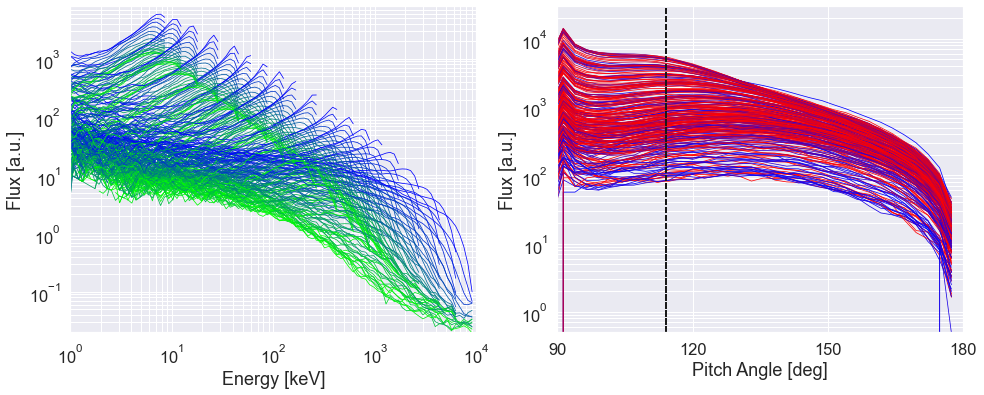

In [11]:
from scipy.interpolate import interp2d

bs_path = 'data/backscatter/'

bs_filenames = os.listdir(bs_path)

run_list = np.array([10,14,20,32,50,71,100,141,200,316,500,707,1000,1414,2000,3162,5000,7071,10000])

dE = np.hstack([np.diff(run_list), np.diff(run_list)[-1]])

pa_list  = np.arange(0, 75, 5)

# Dumb code
def getNumber(x):
    if x == 10:
        return 1
    elif x == 20:
        return 2
    elif x == 50:
        return 3
    elif x == 100:
        return 4
    elif x == 200:
        return 5
    elif x == 500:
        return 6
    elif x == 1000:
        return 7
    elif x == 2000:
        return 8
    elif x == 5000:
        return 9
    elif x == 10000:
        return 10
    else:
        return 0
    
    
def processBackscatterData(filename):
        
    # Get beam energy and pitch angle from filename
    st = re.findall(r'\d+', filename)
    
    energy     = int(st[0])
    pitchAngle = int(st[-1])
        
    # Read in data
    data_tmp = pd.read_csv(bs_path + filename, names=['px', 'py', 'pz'], header=None, sep=',', engine='c')
    
    # Calculate energy
    E = np.linalg.norm(data_tmp.values, axis=1)
        
    # Remove energy from momentum direction (renormalize)
    data_tmp /= E[:,np.newaxis]
    
    # Rotatation angle into magnetic reference frame at PFISR latitude
    untilt_angle = -(np.pi + 12.682 * np.pi / 180);

    # Rotate about x
    data_tmp.py = ( np.cos(untilt_angle) * data_tmp.py - np.sin(untilt_angle) * data_tmp.pz )
    data_tmp.pz = ( np.sin(untilt_angle) * data_tmp.py + np.cos(untilt_angle) * data_tmp.pz )
    
    # Calculate pitch angle
    PA = np.rad2deg( np.arctan2( np.sqrt(data_tmp.px**2 + data_tmp.py**2), data_tmp.pz ) )

    PAbins = np.linspace(0, 180, 70)
    Ebins  = np.logspace(0, 4, 100)
    
    Ehisto = np.histogram(E, bins=Ebins);
    
    PAhisto = np.histogram(PA, bins=PAbins);
    
    im = np.histogram2d(E, PA, bins=[Ebins, PAbins])#, norm=LogNorm());

    # Energy histo, pitch angle histo, 2d histo, then metadata as tuple
    return Ehisto, PAhisto, im, (energy, pitchAngle)


plt.figure(figsize=(16,6)); 

D = {}
for ind, file in enumerate(bs_filenames): 

    Re = processBackscatterData(file)
        
    eBins  = Re[2][1]
    paBins = Re[2][2]
    
    sinAdjustement = np.sin(np.deg2rad(paBins[:-1]-90 + np.diff(paBins)))
    binWidths      = np.diff(eBins)
    
    X, Y   = np.meshgrid(eBins[:-1], paBins[:-1])

    tmp1 = np.fliplr( Re[2][0]  / sinAdjustement[np.newaxis,:] / binWidths[:,np.newaxis] )
    
    tmp1[tmp1 < 0] = 0
    
    f = interp2d(eBins[:-1], paBins[:-1], tmp1.T, kind='linear', bounds_error=True)
    
    # Just store the interpolater!
    D[(Re[3][0], Re[3][1])] = f
    
    
    tmp2 = Re[0][0]/binWidths
    tmp2[tmp2 < 1e-4] = np.nan
    
    plt.subplot(1,2,1); plt.grid(True, which='both')
    plt.plot(eBins[:-1], savgol_filter(tmp2, 3, 1), c=[0, 1-Re[3][1]/pa_list[-1], Re[3][1]/pa_list[-1]], linewidth=0.75)
    plt.xlabel('Energy [keV]')
    plt.ylabel('Flux [a.u.]')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(2e-2, 8e3)
    plt.xlim(1e0, 1e4)
    
    
    plt.subplot(1,2,2); plt.grid(True, which='both')
    plt.vlines(114, 5e-1, 3e4, linestyle='--', color='k')
    plt.vlines(66, 1e0, 5e3, linestyle='--', color='k')
    plt.vlines(90, 1e0, 5e3, linestyle='-', color='k')
    plt.plot(paBins[:-1], savgol_filter(Re[1][0] / sinAdjustement, 3, 1), c=[1 - getNumber(Re[3][0])/10, 
                                                        0, 
                                                        getNumber(Re[3][0])/10],
                                                    linewidth=0.75)
    plt.xticks([90, 120, 150, 180])
    plt.xlim(90, 180)
    plt.ylim(5e-1, 3e4)
    plt.yscale('log')
    plt.xlabel('Pitch Angle [deg]')
    plt.ylabel('Flux [a.u.]')
    
    
#plt.savefig('backscatter_results.pdf', bbox_inches='tight')

# Fitting and plotting routine

In [12]:
from scipy.optimize import minimize

def minSurface90only(weights, resampledD):
    
    # Reshape weights from scipy.optimize.minimize() reordering
    weights = np.reshape(weights, [RUNLISTLIMIT, len(pa_list)], order='F')
        
    # Grab one resampled backscatter profile to get surface shape
    surf = np.zeros( resampledD[(100, 0)].shape )
    
    for ind1, ene in enumerate(run_list[:RUNLISTLIMIT]):
        
        for ind2, pa in enumerate(pa_list):
            
            surf += weights[ind1, ind2] * resampledD[(ene, pa)]
            
    return surf

def costFnc(weights, test_data, resampD, costType):
    
    if costType is "LS":
        Arr = ( test_data - minSurface90only(weights, resampD) )**2
        f = np.sum( Arr[:] )
        
    elif costType is "LLS":
        Arr = np.log( test_data / minSurface90only(weights, resampD).T )**2
        f = np.nansum( Arr[:] )
        
    elif costType is "Chi2":
        E = minSurface90only(weights, resampD).T
        Arr = ( ( test_data - E ) / E )**2
        f = np.nansum( Arr[:] )
        
    else: 
        raise ValueError("Choose a cost function type!")

    return f

def fitSurface(e_bins, pa_bins, data):

    # Backscattered data
    resampledD = {}
    for key in D.keys():
        if key[0] <= run_list[RUNLISTLIMIT]:
            resampledD[key] = D[key](e_bins, pa_bins[pa_bins > ALCANGLE]-90)
    
    costFnc_imp = lambda x: costFnc(x, data[:, pa_bins > ALCANGLE], resampledD, costType="LLS")

    bounds = ()
    for i in range(0, int(RUNLISTLIMIT*len(pa_list))):
        bounds += ((0, None),)

    Nmc  = 1     # Number of Monte Carlo evaluations
    cost = 1e10   # Initial high cost to trip if statement in loop

    # Monte Carlo over random optimizer starting points due to non-QP problem
    for i in range(0, Nmc):
        
        tmp_X = minimize(costFnc_imp, x0=1e2*np.random.rand(RUNLISTLIMIT, len(pa_list)), 
                         bounds=bounds, tol=1e-15,
                        options={'disp': True, 'ftol':0.01, 'maxiter':200})

        if tmp_X.fun < cost:
            cost = tmp_X.fun
            X    = tmp_X
    
    # Loss cone data
    fForward = interp2d(e_bins, pa_bins[pa_bins < LCANGLE], data[:, pa_bins < LCANGLE].T, kind='linear', 
                        bounds_error=False, fill_value=0)

    greenCoefs = 1.5e-2 * fForward(run_list, pa_list).T
     
    return X.x.reshape([RUNLISTLIMIT, len(pa_list)], order='F'), minSurface90only(X.x, resampledD), greenCoefs
            
def plotIonizationProfile(weights, i, norm, color):
    
    resultIoniE = 0
    resultIoniP = 0
    resultBS    = 0
    counter = np.zeros([len(pa_list), len(run_list[:RUNLISTLIMIT])])
    for ind2, pa in enumerate(pa_list):
        for ind1, ene in enumerate(run_list[:RUNLISTLIMIT]):

            resultIoniE += weights[ind1, ind2] * D_mono[('electron', 'ioni', ene, pa)][0] * \
            dE[ind1] * 1e3 * np.deg2rad(5) / 1e5 / (2 * np.pi * np.cos(np.deg2rad(pa))) / (ene * 1e3) / 133

            resultIoniP += weights[ind1, ind2] * D_mono[('photon', 'ioni', ene, pa)][0] * \
            dE[ind1] * 1e3 * np.deg2rad(5) / 1e5 / (2 * np.pi * np.cos(np.deg2rad(pa))) / (ene * 1e3) / 133 / 100
            
            counter[ind2, ind1] += 1

    Ie = savgol_filter(resultIoniE, 1, 0) / 3.5e-2
    Ip = savgol_filter(resultIoniP, 1, 0) / 3.5e-2
    I  = Ie + Ip

    h = np.arange(0, 500)
            
    #plt.figure(figsize=(8,8)); 
    plt.grid(True, which='both')
    
    if color == 'blue':
        label1='Electrons'
        label2='Photons'
        label3='Total'
    else:
        label1=None
        label2=None
        label3=None
    
    
    factor = norm / np.trapz(I, x=h*1e5) 
    I  *= factor
    Ip *= factor
    Ie *= factor
    
    
    print("Factor = %.4e" % factor)
    
    plt.semilogx(Ie, h, '--', c=color, label=label1);
    plt.semilogx(Ip, h,       c=color, linestyle='dashdot', label=label2);
    plt.semilogx(I,  h,       c=color, label=label3);

    plt.legend()
    plt.ylim(0, 150);
    plt.xlabel('Ionization Rate [cm$^{-3}$ s$^{-1}$]')
    plt.ylabel('Altitude [km]');
    
    T = np.trapz(I, x=h*1e5)
    
    print("Event %.0f, total ionization: %.4e eV cm^-2 s^-1, %.4e cm^-2 s^-1" % (i, 35*T, T))
    
    return factor
            
def plot2D_data_with_fit(e_bins, pa_bins, counts, fit, weights, greenCoefs, i, saveOn):
    
    norm = getTotalFlux(e_bins, pa_bins, counts, 0, LCANGLE) / 35
    
    path = './figures/'
    
    plot2D_data(e_bins, pa_bins[pa_bins > ALCANGLE], counts[:, pa_bins > ALCANGLE])
    
    if saveOn == 1:
        plt.savefig(path + 'Event_%.0f_data.pdf' % i, bbox_inches='tight')
    else:
        plt.suptitle('Event %.0f' % i)

    plot2D_data(e_bins, np.flip(pa_bins[pa_bins > ALCANGLE]), fit.T)
    
    if saveOn == 1:
        plt.savefig(path + 'Event_%.0f_fit.pdf' % i, bbox_inches='tight')
    else:
        plt.suptitle('Fit')


    plot2D_data(e_bins, np.flip(pa_bins[pa_bins > ALCANGLE]), 
                100 * np.abs(counts[:, pa_bins > ALCANGLE] - fit.T) / counts[:, pa_bins > ALCANGLE])
    
    if saveOn == 1:
        plt.savefig(path + 'Event_%.0f_residuals.pdf' % i, bbox_inches='tight')
    else:
        plt.suptitle('Residuals')
    
    plt.figure(figsize=(8,8))
    print("Forward: ", end="")
    F1 = plotIonizationProfile(weights, i, norm, color='blue')
    print("Inverse: ", end="")
    F2 = plotIonizationProfile(greenCoefs, i, norm, color='red')
    #plt.xlim(1e-3, 1e3)
        
    if saveOn == 1:
        plt.xlim(1e-5, 5e2)

        plt.savefig(path + 'Event_%.0f_ioni.pdf' % i, bbox_inches='tight')
    else:    
        plt.title('Predicted Ionization Profile');
        
    return F1, F2
        

/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: divide by zero encountered in true_divide
/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in true_divide
/home/gdberla/anaconda3/envs/p

Forward: Factor = 1.0878e-01
Event 1, total ionization: 4.2542e+09 eV cm^-2 s^-1, 1.2155e+08 cm^-2 s^-1
Inverse: Factor = 5.3245e-01
Event 1, total ionization: 4.2542e+09 eV cm^-2 s^-1, 1.2155e+08 cm^-2 s^-1


/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


Forward: Factor = 7.3921e-01
Event 2, total ionization: 2.7782e+10 eV cm^-2 s^-1, 7.9377e+08 cm^-2 s^-1
Inverse: Factor = 1.3752e+00
Event 2, total ionization: 2.7782e+10 eV cm^-2 s^-1, 7.9377e+08 cm^-2 s^-1
Forward: Factor = 6.3366e-01
Event 3, total ionization: 2.4106e+10 eV cm^-2 s^-1, 6.8873e+08 cm^-2 s^-1
Inverse: Factor = 1.0738e+00
Event 3, total ionization: 2.4106e+10 eV cm^-2 s^-1, 6.8873e+08 cm^-2 s^-1
Forward: Factor = 1.8325e-01
Event 4, total ionization: 6.4145e+09 eV cm^-2 s^-1, 1.8327e+08 cm^-2 s^-1
Inverse: Factor = 1.8431e-01
Event 4, total ionization: 6.4145e+09 eV cm^-2 s^-1, 1.8327e+08 cm^-2 s^-1
Forward: Factor = 3.7051e-01
Event 5, total ionization: 1.3068e+10 eV cm^-2 s^-1, 3.7338e+08 cm^-2 s^-1
Inverse: Factor = 7.3904e-01
Event 5, total ionization: 1.3068e+10 eV cm^-2 s^-1, 3.7338e+08 cm^-2 s^-1


/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Forward: Factor = 2.2630e-01
Event 6, total ionization: 7.3848e+09 eV cm^-2 s^-1, 2.1099e+08 cm^-2 s^-1
Inverse: Factor = 1.9164e+00
Event 6, total ionization: 7.3848e+09 eV cm^-2 s^-1, 2.1099e+08 cm^-2 s^-1
Forward: Factor = 2.0771e-01
Event 7, total ionization: 7.6841e+09 eV cm^-2 s^-1, 2.1954e+08 cm^-2 s^-1
Inverse: Factor = 2.8466e-01
Event 7, total ionization: 7.6841e+09 eV cm^-2 s^-1, 2.1954e+08 cm^-2 s^-1
Forward: Factor = 1.2679e-01
Event 8, total ionization: 4.2542e+09 eV cm^-2 s^-1, 1.2155e+08 cm^-2 s^-1
Inverse: Factor = 5.3245e-01
Event 8, total ionization: 4.2542e+09 eV cm^-2 s^-1, 1.2155e+08 cm^-2 s^-1


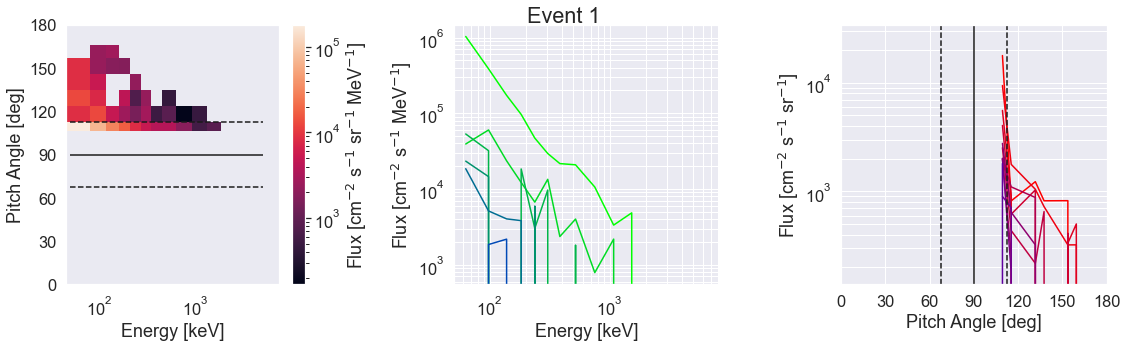

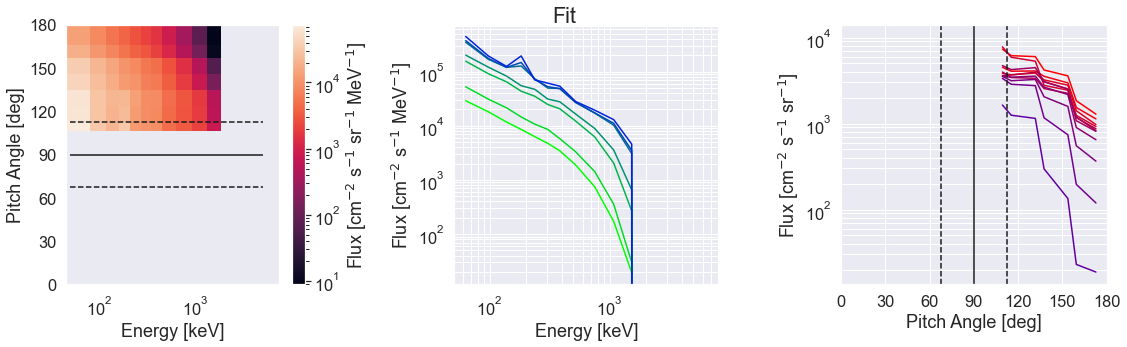

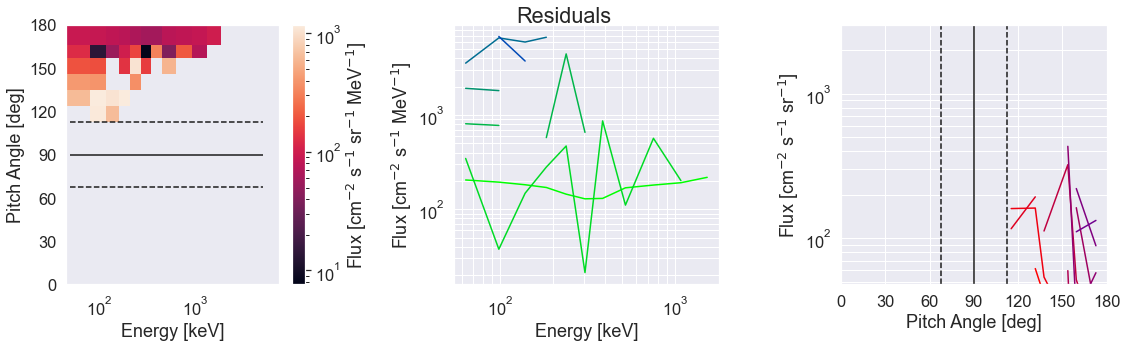

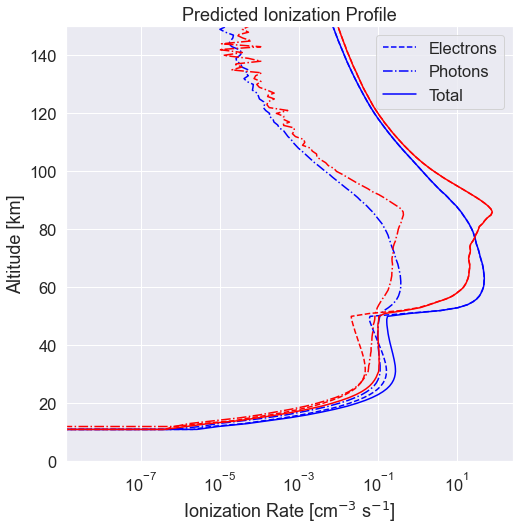

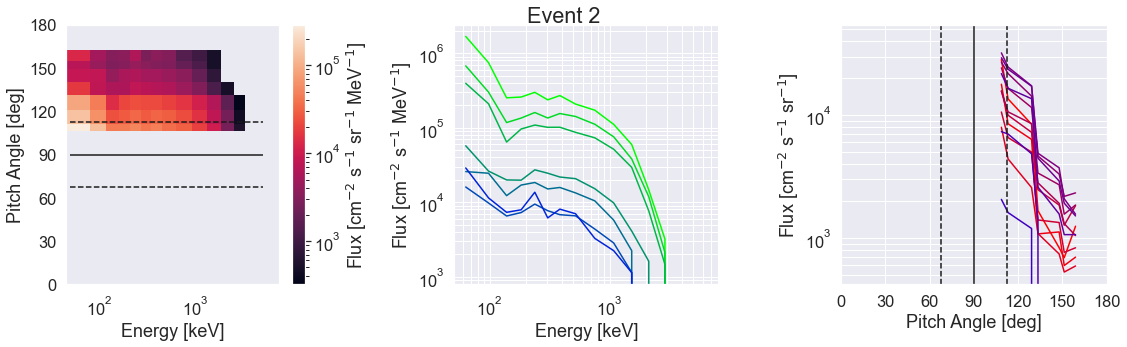

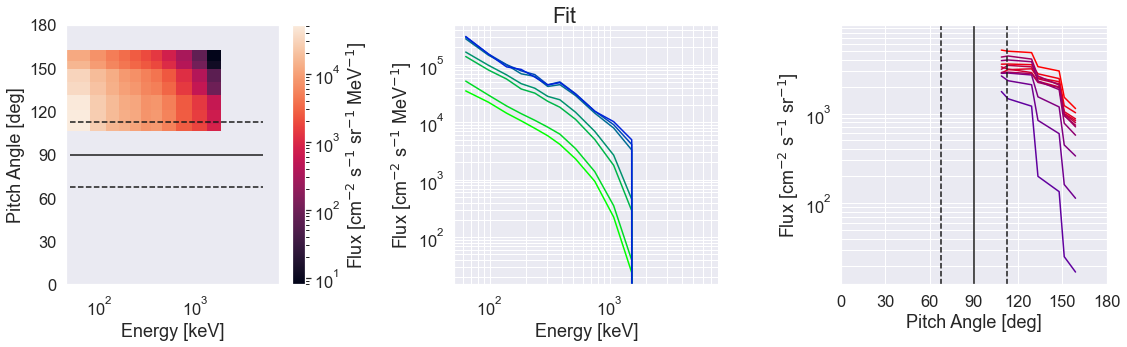

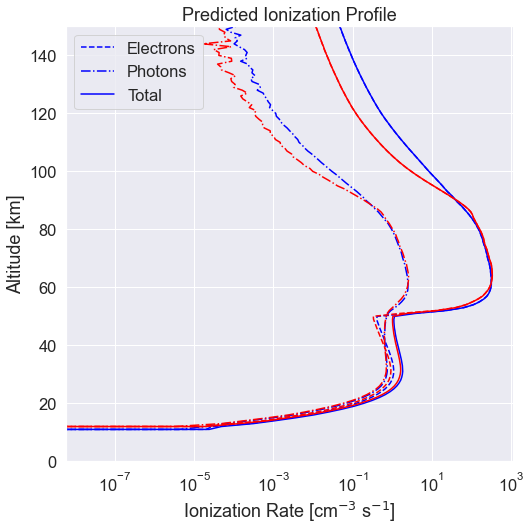

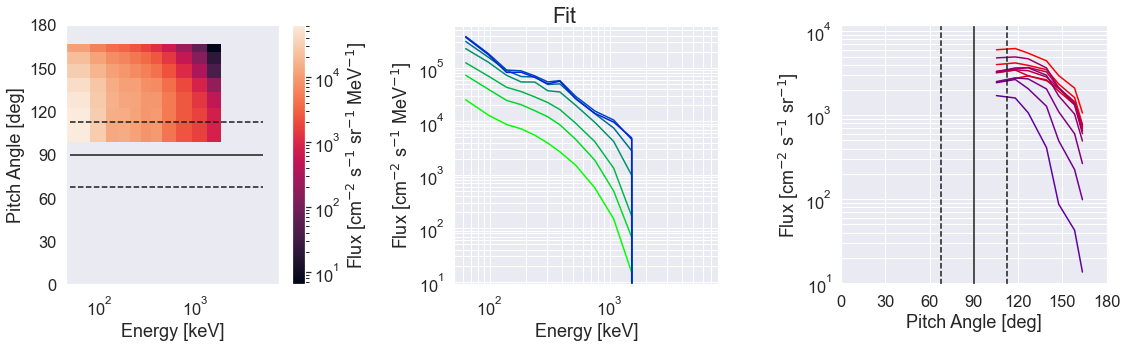

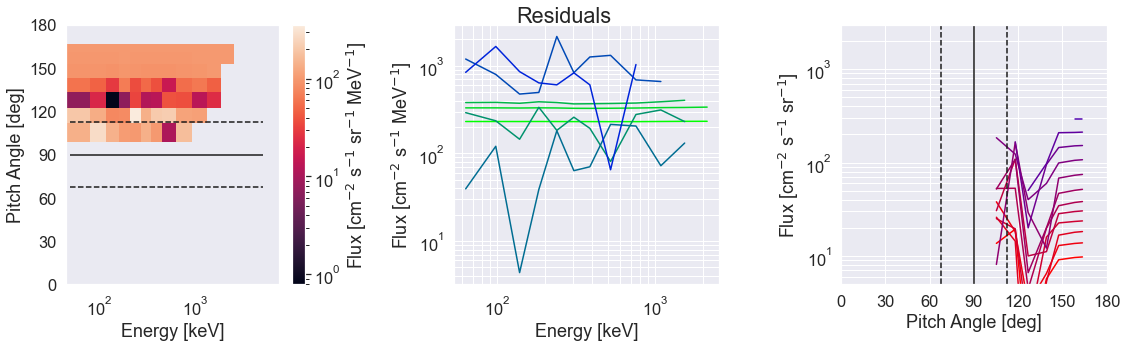

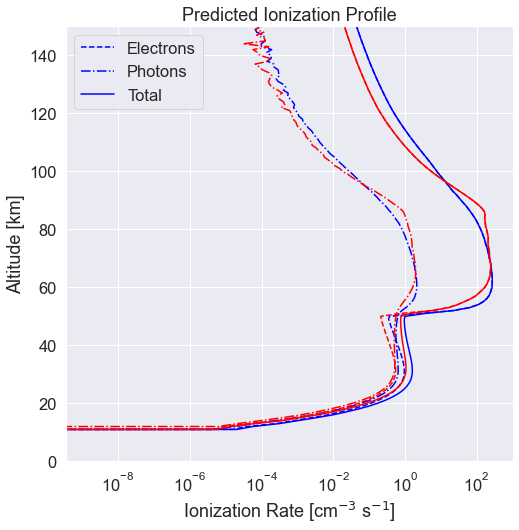

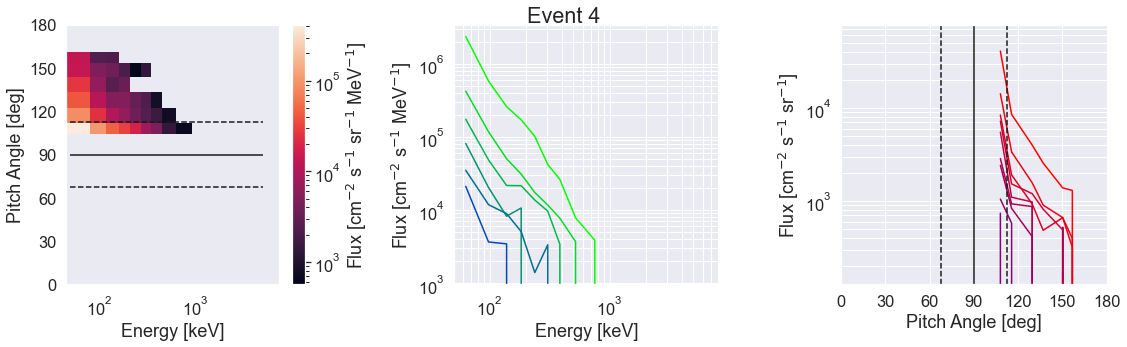

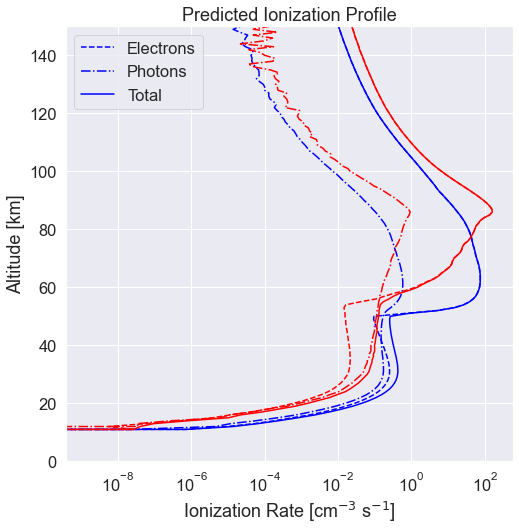

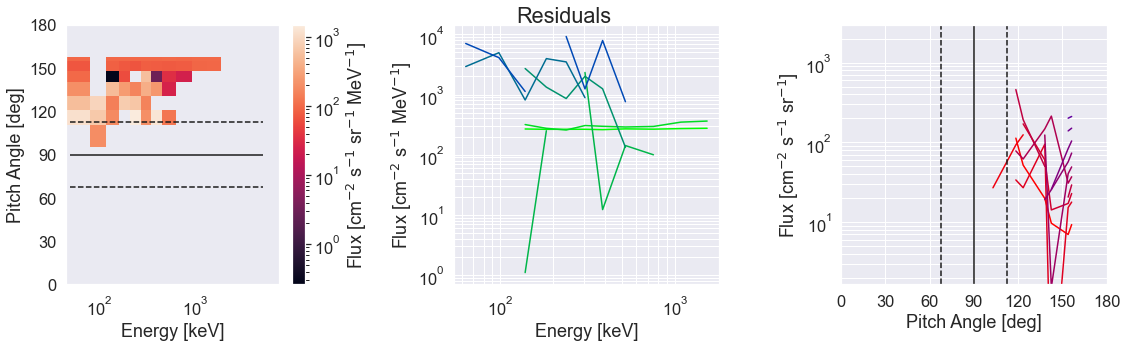

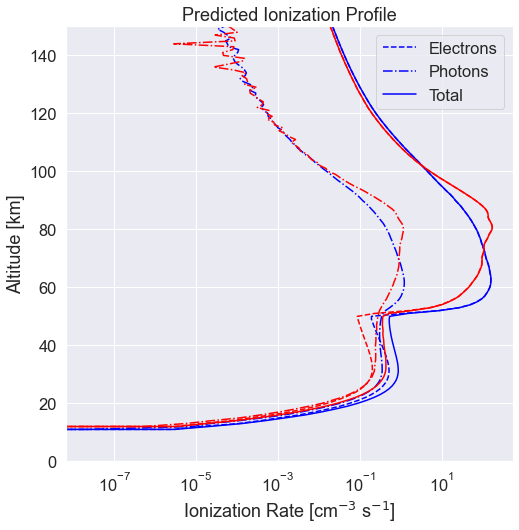

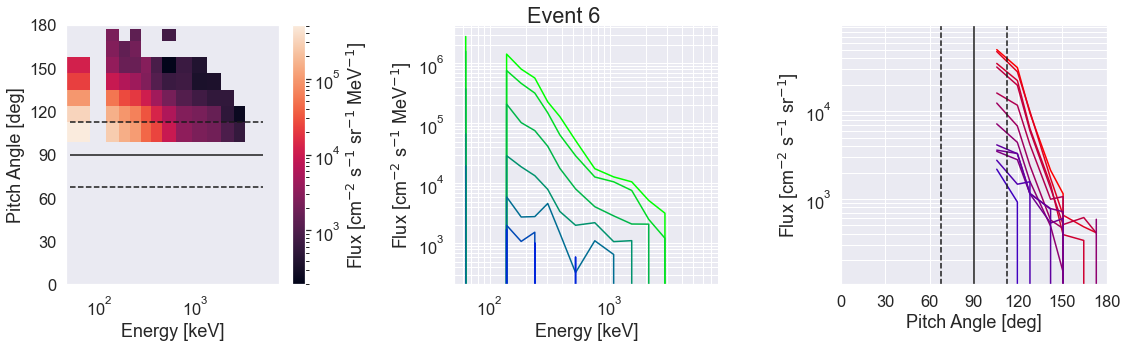

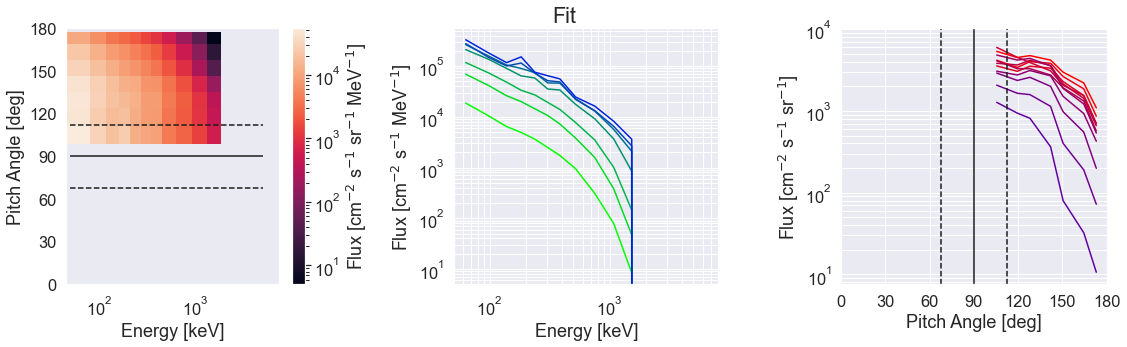

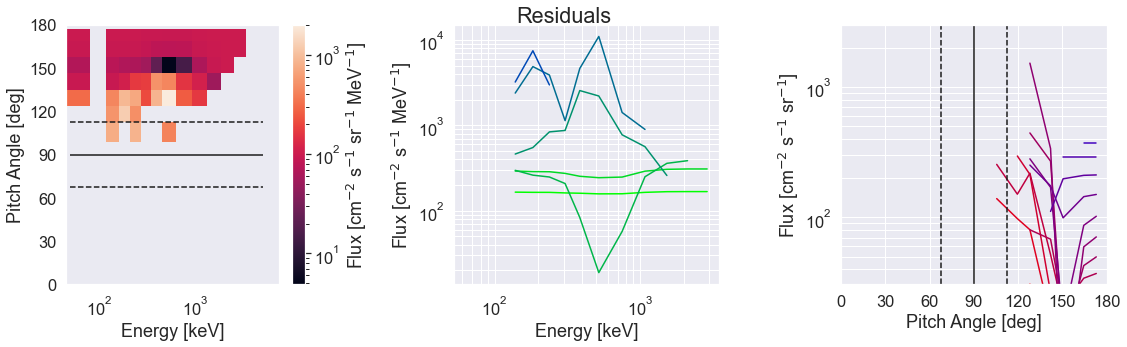

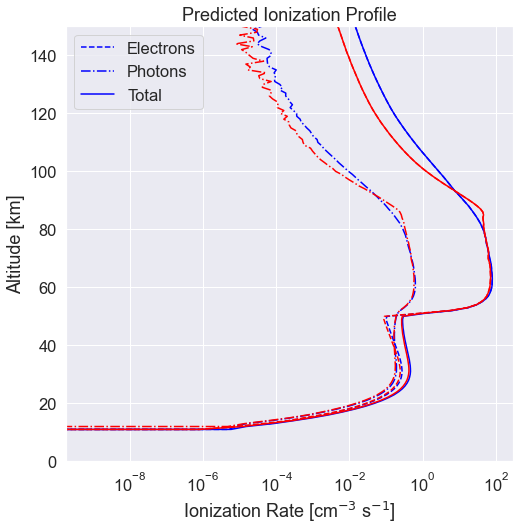

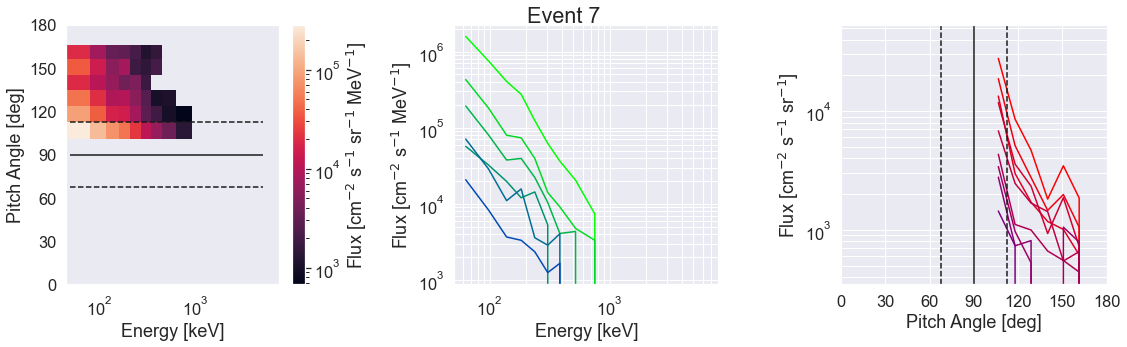

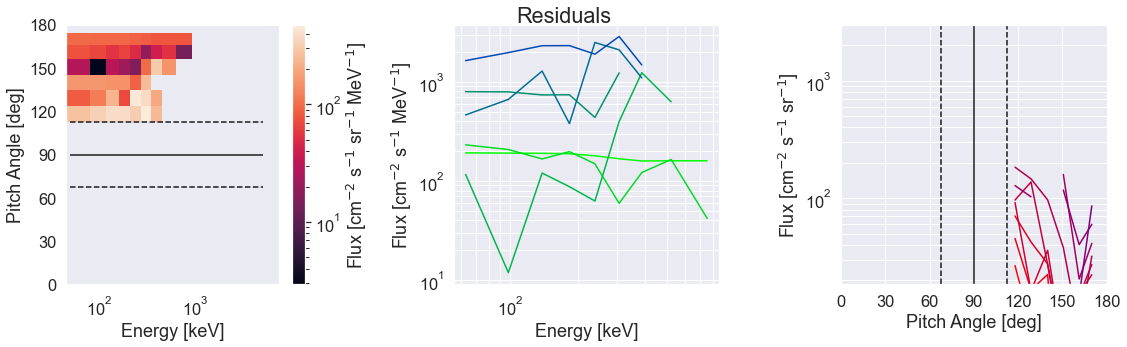

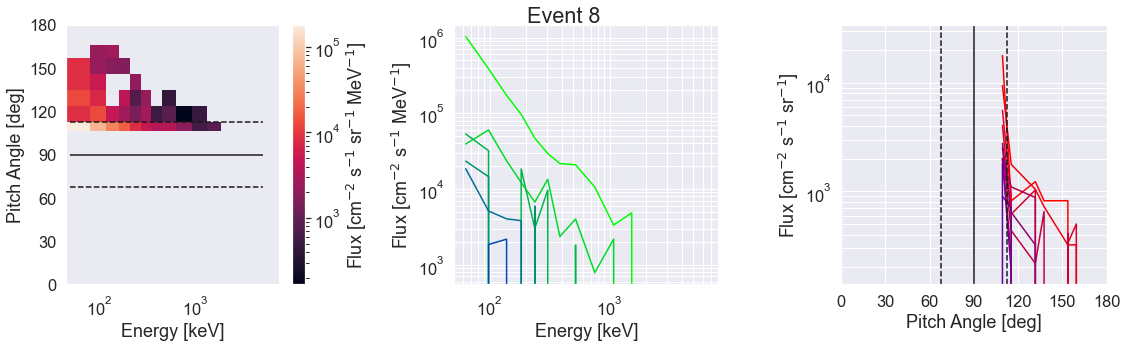

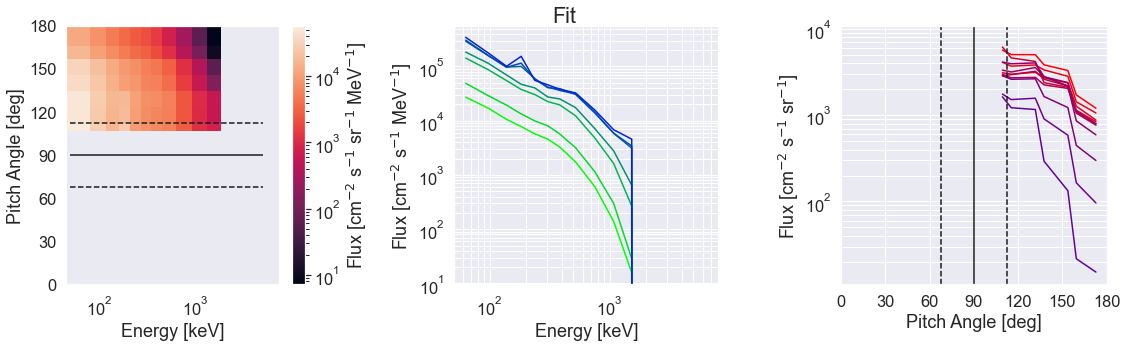

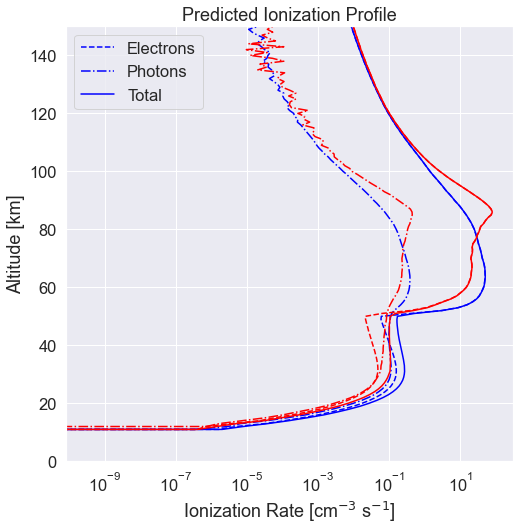

In [13]:
saveOn = 0

factor = np.zeros([8, 2])
for i in range(0, 8):

    pa_bins, counts = get_ELFIN_data(i)
    
    weights, surf, greenCoefs = fitSurface(e_bins, pa_bins, counts.values)

    factor[i,:] = plot2D_data_with_fit(e_bins, pa_bins, counts.values, surf, weights, greenCoefs, i+1, saveOn)
    #plt.savefig('event%.0fioni.pdf' % i, bbox_inches='tight')

# Averaged EMIC precipitation ELFIN data

/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in true_divide


Forward: Factor = 9.6284e-01
Event 0, total ionization: 3.3807e+10 eV cm^-2 s^-1, 9.6590e+08 cm^-2 s^-1
Inverse: Factor = 1.2135e+00
Event 0, total ionization: 3.3807e+10 eV cm^-2 s^-1, 9.6590e+08 cm^-2 s^-1


(0.9628395046056974, 1.213537727756586)

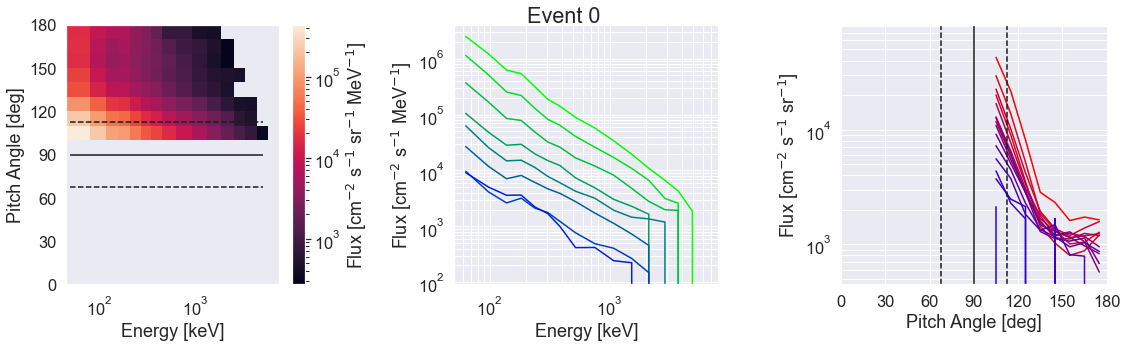

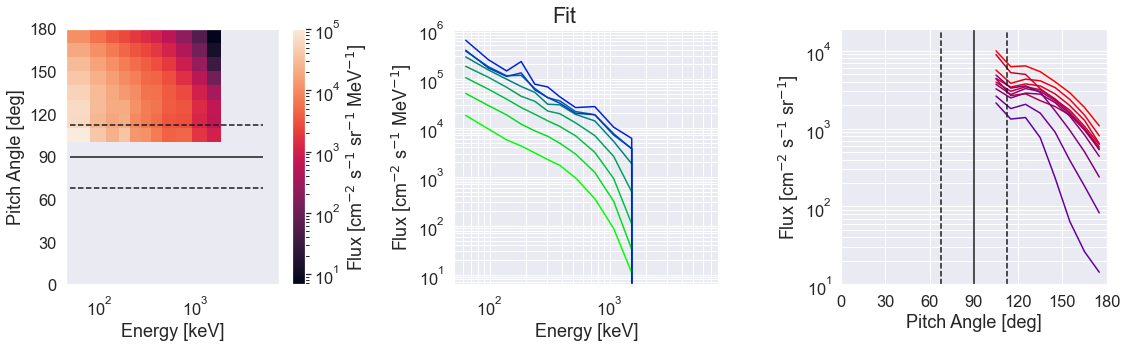

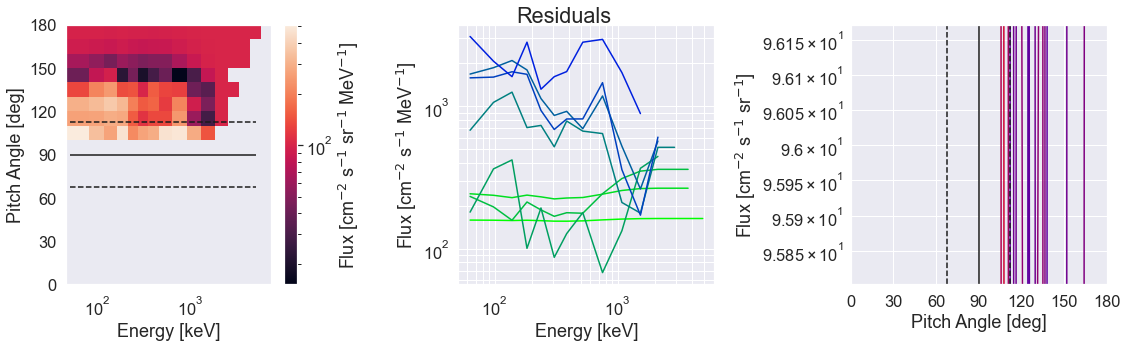

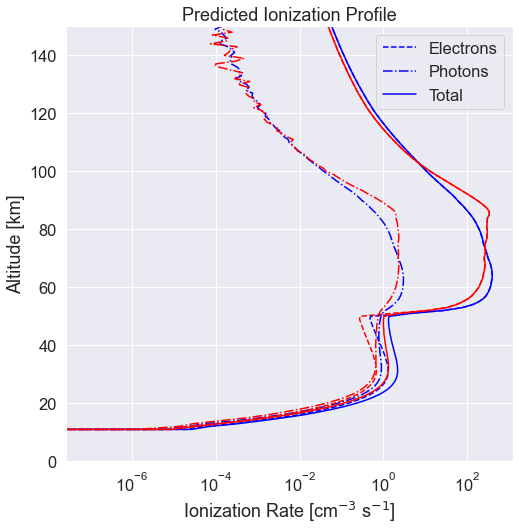

In [14]:
weights, surf, greenCoefs = fitSurface(e_bins, avg_pa_bins, avg_data.values)

plot2D_data_with_fit(e_bins, avg_pa_bins, avg_data.values, surf, weights, greenCoefs, 0, saveOn)
#plt.xlim(1e-4, 1e3)
#plt.savefig('ELFIN_atmos_ionization.pdf', bbox_inches='tight')

(0.6499999999999999, 8.35)

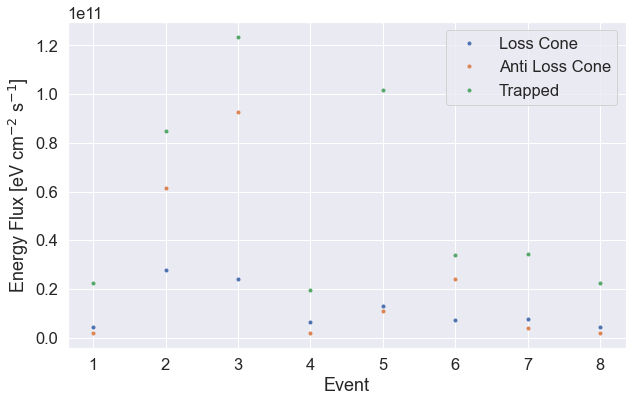

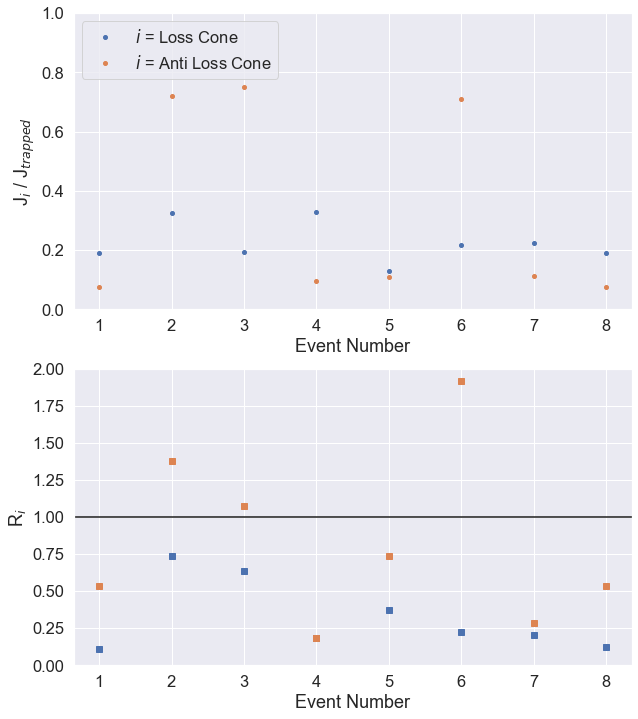

In [15]:
def getNumberFlux(e_bins, pa_bins, counts, alpha1, alpha2):

    try:
        counts = counts.values
    except:
        counts = counts
    
    # Restrict pitch angle bins to those of interest
    r_pa_bins = pa_bins[(pa_bins > alpha1) & (pa_bins < alpha2)]
    
    MeV_to_eV = 1e-6
    
    intFlux = 2 * np.pi * np.trapz( 
        np.trapz(counts[:, ((pa_bins > alpha1) & (pa_bins < alpha2))] * 
                 e_bins[:,np.newaxis]  * 1e3 , 
                 x=e_bins*1e3, axis=0) * np.sin(np.deg2rad(r_pa_bins)), 
                 x=np.deg2rad(r_pa_bins))
    
    return intFlux


fs = np.zeros(8)
ft = np.zeros(8)
fb = np.zeros(8)
for i in range(0, 8):
    
    pa_bins, counts = get_ELFIN_data(i)
    
    f_fs_ene     = getTotalFlux(e_bins, pa_bins, counts, 0, LCANGLE)
    f_bs_ene     = getTotalFlux(e_bins, pa_bins, counts, ALCANGLE, 180)
    
    fs[i] = f_fs_ene
    fb[i] = f_bs_ene
    
    f_fs_n       = getNumberFlux(e_bins, pa_bins, counts, 0, LCANGLE)
    f_bs_n       = getNumberFlux(e_bins, pa_bins, counts, ALCANGLE, 180)
    
    f_t_ene      = getTotalFlux(e_bins, pa_bins, counts, LCANGLE, ALCANGLE)
    f_t_n        = getNumberFlux(e_bins, pa_bins, counts, LCANGLE, ALCANGLE)
    
    ft[i] = f_t_ene
    
    #print("Event %.0f" % (i+1))
    #print("LC: %.3e eV cm-2 s-1, ALC: %.3e eV cm-2 s-1, ALC/LC: %.2f" % (f_fs_ene, f_bs_ene, f_bs_ene/f_fs_ene))
    #print("LC: %.3e cm-2 s-1, ALC: %.3e cm-2 s-1" % (f_fs_n, f_bs_n))
    #print('')
    
absc = np.arange(1, 9)
    
plt.figure(figsize=(10,6))
plt.plot(absc, fs, '.', label='Loss Cone')
plt.plot(absc, fb, '.', label='Anti Loss Cone')
plt.plot(absc, ft, '.', label='Trapped')
plt.xlabel('Event')
plt.ylabel('Energy Flux [eV cm$^{-2}$ s$^{-1}$]');
plt.legend()

plt.figure(figsize=(10,12)); plt.subplot(2,1,1)
plt.plot(absc, fs/ft, '.', markersize=8, label='$i$ = Loss Cone')
plt.plot(absc, fb/ft, '.', markersize=8, label='$i$ = Anti Loss Cone')
plt.xlabel('Event Number')
plt.ylabel('J$_i$ / J$_{trapped}$');
plt.legend(ncol=1, loc='upper left');
plt.ylim(0, 1)


ax = plt.subplot(2,1,2); ax.grid(True, which='both')
ax.plot(absc, factor[:,0], 's', label='R$_{forward}$')
ax.plot(absc, factor[:,1], 's', label='R$_{inverse}$');
ax.set_ylim(0, 2)
ax.set_ylabel('R$_i$');
ax.hlines(1, 0, 9, 'k')
#ax.set_xlim(0.8, 8.2);
plt.xlabel('Event Number')
ax.set_xlim(0.6499999999999999, 8.35)

#plt.savefig('model_performance.pdf', bbox_inches='tight')